##### Gaussian Process for Western Wheat

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [134]:
datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_max_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_23.csv'

df = pd.read_csv(datapath)
Num_farms = pd.unique(df.pixel).size
print ('there are {} unique farms in loaded df'.format(Num_farms))
df_unique =  df.set_index('pixel')
df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index value

farm_idx = df.pixel.values.astype(int)
N_farms = pd.unique(df.pixel).size
#====================================
# reindexing pixels from 0-Nfarms
#====================================
zero_farm_idx = np.zeros_like(farm_idx)

for i,farm in enumerate((np.unique(farm_idx))):
        for j in np.where(farm_idx == farm): 
            zero_farm_idx[j] = int(i)   
            
##########################################################
# This keeps order only becuase df is sorted by farm_idx
#########################################################
df['farm'] = zero_farm_idx

there are 164 unique farms in loaded df


In [3]:
###########################
# ==== distance matrix ====
###########################

from scipy.spatial import distance_matrix
from geopy.distance import geodesic

    

def distancematrix(df, distance_calc=True, sparse=True, dlim=100):
    unique_farms = pd.unique(df.pixel)
    distance = np.zeros((unique_farms.size,unique_farms.size))
    df_unique = df.set_index('pixel')
    df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index values

    for i in range(unique_farms.size):
        lat_lon_i = df_unique.Latitude.iloc[i],df_unique.Longitude.iloc[i]
        for j in range(unique_farms.size):
            lat_lon_j = df_unique.Latitude.iloc[j],df_unique.Longitude.iloc[j]
            if distance_calc == True:
                distance[i,j] = geodesic(lat_lon_i, lat_lon_j).miles
            if sparse == True and distance[i,j]>dlim:
                distance[i,j] = np.NaN
    return distance


distance = distancematrix(df, distance_calc=True, sparse=False, dlim=75)

Dmatsq = np.power(distance, 2)

In [454]:
#plt.figure(figsize=(16,16))
#sns.heatmap(Kij);
#(distance.size-np.isnan(distance).sum())/distance.size

In [106]:
GP = {}
for i in range(3):
    GP['GP' + str(i)] = i

In [128]:

np.linspace(1e-3,5e-5,8)

array([1.00000000e-03, 8.64285714e-04, 7.28571429e-04, 5.92857143e-04,
       4.57142857e-04, 3.21428571e-04, 1.85714286e-04, 5.00000000e-05])

In [131]:
etas = np.array([1,.1,.3,.5,.7,1,.7,.5])
rhos = np.linspace(1e-3,5e-5,8)
trho = {} #empty trace dict to store traces in
# ==== Model I want to reparm =====
GP = {}
counter = 0
for i in range(rhos.size):
    if rhos.size != etas.size:
        raise ValueError('rhos and etas not the same size')
    counter +=1
    with pm.Model() as GP[str(counter)]:

        # ====== covariance matrix ========
        #etasq = pm.HalfCauchy('etasq', .7) # sets maximum covariance ij
        etasq = etas[i] # pm.Uniform('etasq', 0,1) 
        #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
        rhosq = rhos[i] # pm.Uniform('rhosq',lower=0,upper=1e-5)
        sigmay = 1e-2
        # will have very small posterior because distances are so large in Dmatsq
        Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))
        #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed

        # ========== gaussian process ===========
        w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
        a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
        #a = np.zeros(Num_farms)
        # ========== Linear Model =============== 
        u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
        #============ Likelihood ==============
        sigma = pm.Uniform('sigma', 0,2)
        #sigma = .8
        y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

        trho["trace{}".format(counter)] = pm.sample(2000,tune=500,chains=2)
    #tt = pm.sample(1000,tune=500,chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:14<00:00, 347.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:29<00:00, 167.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:33<00:00, 148.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains:  51%|█████     | 2540/5000 [00:16<00:15, 156.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_dia

KeyboardInterrupt: 

In [136]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    #etasq = pm.HalfCauchy('etasq', .7) # sets maximum covariance ij
    etasq = pm.Uniform('etasq', 0,1) 
    #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
    rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-2
    # will have very small posterior because distances are so large in Dmatsq
    Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed

    # ========== gaussian process ===========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    #sigma = .8
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(2000,tune=500,chains=2)

with pm.Model() as GP_est:

    # ====== covariance matrix ========
    #etasq = pm.HalfCauchy('etasq', .7) # sets maximum covariance ij
    etasq = 1 #pm.Uniform('etasq', 0,1) 
    #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
    rhosq = 1e-4 # pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-2
    # will have very small posterior because distances are so large in Dmatsq
    Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed

    # ========== gaussian process ===========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    #sigma = .8
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace_est = pm.sample(3000,tune=500,chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w, rhosq, etasq]
Sampling 2 chains: 100%|██████████| 5000/5000 [05:33<00:00, 14.59draws/s]
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4115984306104429, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8878821496568596, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:24<00:00, 282.30draws/s]
The n

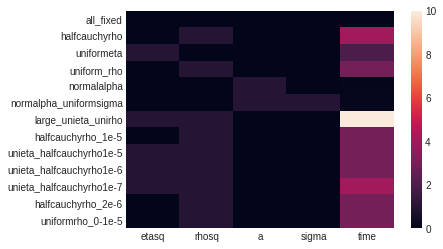

In [179]:
computetime = {'all_fixed':[0,0,0,0,.05],'halfcauchyrho':[0,1,0,0,4],'uniformeta':[1,0,0,0,2],
               'uniform_rho':[0,1,0,0,3],'normalalpha':[0,0,1,0,.1],
               'normalpha_uniformsigma':[0,0,1,1,.15],'large_unieta_unirho':[1,1,0,0,10.],
              'halfcauchyrho_1e-5':[0,1,0,0,3.],'unieta_halfcauchyrho1e-5':[1,1,0,0,3],
              'unieta_halfcauchyrho1e-6':[1,1,0,0,3],'unieta_halfcauchyrho1e-7':[1,1,0,0,4],
              'halfcauchyrho_2e-6':[0,1,0,0,3.],'uniformrho_0-1e-5':[0,1,0,0,3.],
              'covsigma0.5' : [1,1,1,1,2]}
                    
                             
comptime = pd.DataFrame.from_dict(computetime, orient='index',
   columns=['etasq','rhosq','a','sigma','time'])

sns.heatmap(comptime);

In [207]:
X = df_unique.Latitude.values[:,None]
Xu = X[::]
# ===== reparam ====

with pm.Model() as GP_reparam:
    
    r""" 
    
    Trying to model two levels of a hierarchy, similar to a bayesian hierarchical model, 
    except, using a Gaussian Process to shrink the lower level estimates to the mean of the 
    higher level group. That way I do not have to define discrete groups that each farm belong to, 
    but can share information from farm to farm based on how close it is to other farms.
    This measure of similarity is given by the kernel function which defines a covariance matrix
    for the Gaussian Process. The trick is inserting my linear submodel.
    
    """
    
    # ======== prior intercept =============
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained unique to each farm
    b = pm.Normal('b', 0, .5, shape=Num_farms) # slope to be trained unique to each farm
    # ========== Linear Model =============== 
    u = a[zero_farm_idx]  + b[zero_farm_idx]*df.zprsum3 
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    y = pm.Normal('NDVI', mu=u, sd=sigma, observed=df.zNDVIsum3)
    

    # ========== gaussian process ===========
    #kernel hyperparameter lengthscale
    rho = pm.HalfCauchy('rho', .5)
    rho =.1
    #kernel
    cov = pm.gp.cov.ExpQuad(1,ls=rho)
    gp = pm.gp.MarginalSparse(cov_func=cov)
    # initialize 20 inducing points with K-means
    Xu = pm.gp.util.kmeans_inducing_points(20, X)
    sigma_gp = pm.Normal('sigma_gp',0,.5)
    # slope for the individual farms, need y to be output from y above
    w = gp.marginal_likelihood('w', X=X,Xu=Xu,y=b,noise=sigma_gp,is_observed=False)
    
 

    #trace = pm.sample(1000,tune=100,chains=1)
    #mp = pm.find_MAP()

In [87]:
pm.loo({GP:t['trace1'], GP:t['trace3']})

KeyError: 'trace1'

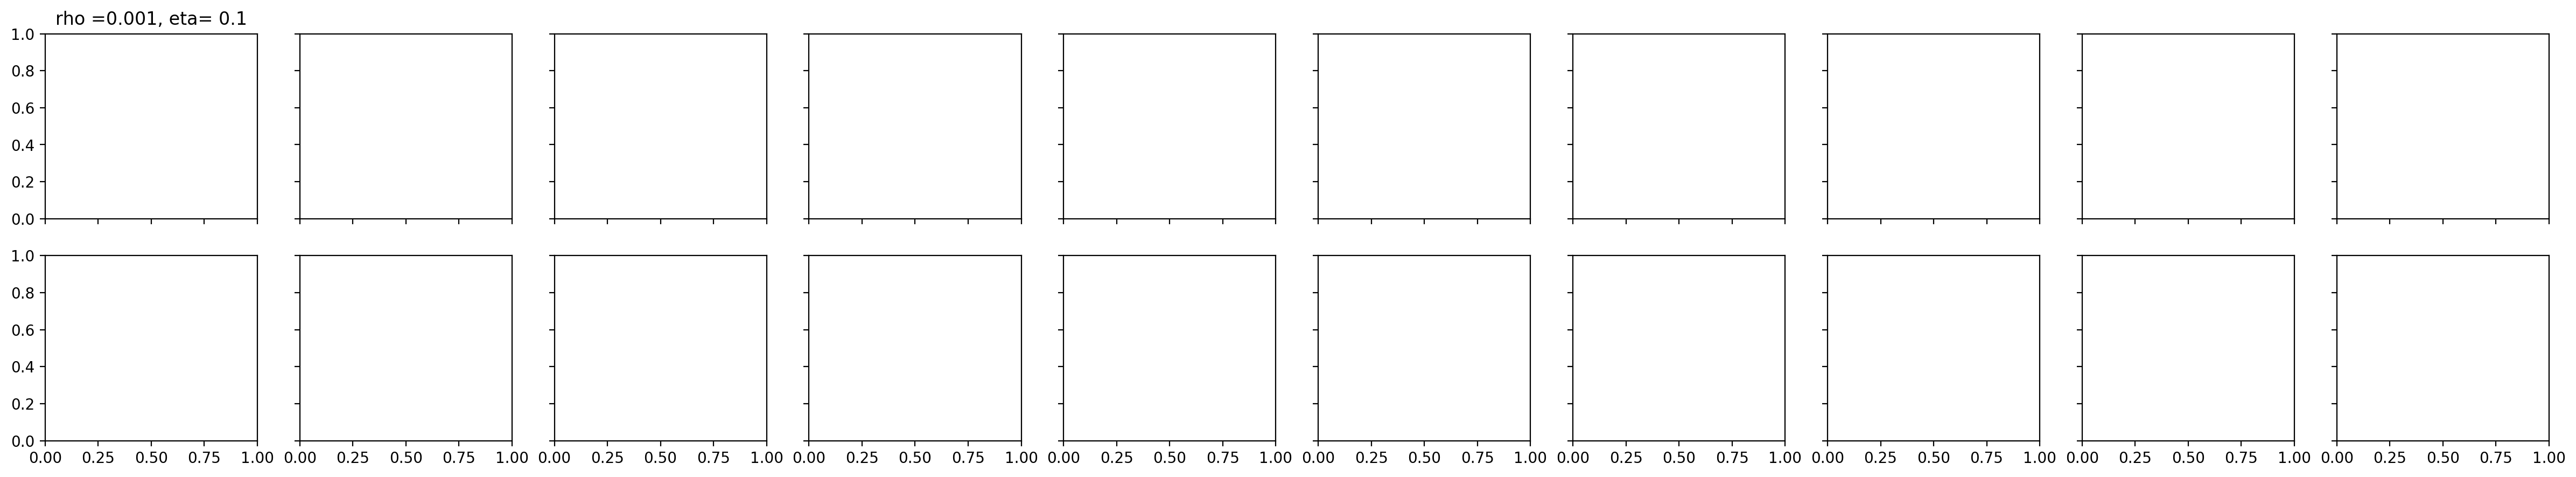

In [109]:
etas = np.array([.1,1])
rhos = np.linspace(1e-3,1e-5,10)
v=.5
fig, ax = plt.subplots(2,10,sharey=True,sharex=True,figsize=(30,5),dpi=200)

c = 0
for i, r in enumerate(rhos):
    for j,e in enumerate(etas):
        ax[j,i].set_title('rho ={}, eta= {}'.format((round(r,6)),e))
        im = ax[j,i].scatter(df_unique.Longitude,df_unique.Latitude,c=trho['trace{}'.format(c+1)]['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
        c += 1

#ax[2,i+1].scatter(df_unique.Longitude,df_unique.Latitude,c=t_highrho['trace{}'.format(i+1)]['w'].mean(axis=0),
#            cmap='coolwarm',vmax=v,vmin=-v,s=6)
    
    
#plt.subplots_adjust(bottom=0.1, right=0.99, top=0.9)
#cax = plt.axes([1, 0.1, 0.015, 0.75]) #right,bottom,width,top 
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='GP smoothed slope $w$');
#plt.savefig('rho_eta_SA_2by10.png');

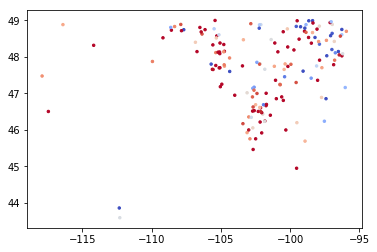

In [96]:
plt.scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
            cmap='coolwarm',vmax=v,vmin=-v,s=6);

In [209]:
# add the GP conditional to the model, given the new X values
X_new = np.linspace(40,50,100)[:,None]#np.linspace(40,50,100)[:,None]
#with GP_reparam:
#    f_pred = gp.conditional("f_pred", X_new)
    
#with GP_reparam:
#    fs =  gp.conditional('fss', X_new)
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
#with GP_reparam:
#    pred_samples = pm.sample_posterior_predictive([trace], vars=[fs], samples=2000)

In [94]:
def linear_pixel(df, p,c,column_x,column_y, LOO=False, cluster=True):
    """
    =========================================================
    Compute simple OLS pixel wise for given pixel/farm p, and cluster c.
    
    LeaveOneOut implented for CV studies. 
    
    if LOO:
        return mu_params_pixel, C_pixel, y_train, x_train, y_test, x_test, n
    =========================================================
    """
    if cluster:
        dfc = df[df.cluster==c]
        dfp = dfc.loc[dfc.pixel==p]
    else:
        dfp = df.loc[df.pixel==p]
    # first mask out potential nan values
    mask = ~np.isnan(dfp[column_x].values) & ~np.isnan(dfp[column_y].values)
    x = dfp[column_x].values[mask]
    y = dfp[column_y].values[mask]
    
    
    if LOO == True:

        # delete one of the y and x values before fitting line
        
        n = np.random.randint(0,y.shape[0]) # one data point left out of training set
        y_test = y[n]   # selecting n test set
        y = np.delete(y,n)  # erase value indexed at n from training set
        x_test = x[n] # selecting n test data
        x = np.delete(x,n) # delete corresponding x value 
            
    G = np.ones_like(x)
    G = np.array((G,x)).T
    # ml2 = [alpha, beta] parameters for least squares
    # ml2 = (G.T@G)-1 @ G.T @ d
    # least squares in matrix form
    A = np.matmul(np.linalg.inv(np.matmul(G.T,G)),  G.T)
    mu_params = np.matmul(A,y)
    mu_params_pixel = mu_params

    # variance in y
    # p.31
    #Cov(ml2) = (Gw.T@Gw)-1
    # assumption iid normal data errors
    # Cov(ml2) = var*(G.T@G)-1
    C =  y.var() * np.linalg.inv(np.matmul(G.T,G))
    C_pixel = C  
    
    if LOO==True:
        return mu_params_pixel, C_pixel, y, x, y_test, x_test, n
    
    else: 
        return mu_params_pixel, C_pixel

In [95]:
df_unique['B_zprsum3'] = 0
column_x='zprsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='zNDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]

In [482]:
t_highrho

{}

(60.0,
 Float64Index([   60.0,   317.0,   327.0,   396.0,   437.0,   445.0,   510.0,
                 524.0,   550.0,   570.0,
               ...
               49414.0, 49448.0, 49464.0, 49471.0, 49550.0, 49564.0, 49633.0,
               49737.0, 49855.0, 49885.0],
              dtype='float64', name='pixel', length=874))

In [473]:
import pickle

with open('t_highrho.p', 'wb') as fp:
    pickle.dump(t_highrho, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
